In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split


In [2]:
# Définition des transformations des données
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Mise à l'échelle des images
    transforms.ToTensor(),         # Conversion en tenseur
    transforms.Normalize([0.5], [0.5])  # Normalisation
])

# Chargement du dataset équilibré (indiquez le chemin correct)
dataset_path = "/kaggle/input/oii-dds-resized-5000/oii-data-resized-implant"
full_dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

# Vérification des classes disponibles
class_names = full_dataset.classes
print(f"Classes : {class_names}")
print(f"Taille totale du dataset : {len(full_dataset)}")


Classes : ['compound', 'double_implants', 'others', 'single_implants', 'steel_ball']
Taille totale du dataset : 25000


In [3]:
# Division du dataset en ensemble d'entraînement, de validation et de test
train_size = int(0.75 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size])

# Création des DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training size : {len(train_dataset)}, Validation size : {len(val_dataset)}, Testing size : {len(test_dataset)}")


Training size : 18750, Validation size : 3750, Testing size : 2500


In [4]:
# Chargement du modèle EfficientNet pré-entraîné
model = models.efficientnet_b0(pretrained=True)

# Modification de la dernière couche pour adapter au nombre de classes
num_classes = len(class_names)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Déplacement du modèle vers le GPU si disponible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 179MB/s]


In [5]:
# Définition de la fonction de perte et de l'optimiseur
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
pip install matplotlib


Note: you may need to restart the kernel to use updated packages.


In [7]:
import matplotlib.pyplot as plt

num_epochs = 20

# Initialisation des listes pour le suivi
train_losses = []
val_losses = []
val_accuracies = []

# Entraînement avec stockage des métriques
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    # Validation après chaque epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / len(val_loader))
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Val Accuracy: {val_accuracies[-1]}%")


Epoch 1/20, Train Loss: 0.11593252364343426, Val Loss: 0.01839897634186022, Val Accuracy: 99.33333333333333%
Epoch 2/20, Train Loss: 0.04174264980580002, Val Loss: 0.019227660037065986, Val Accuracy: 99.52%
Epoch 3/20, Train Loss: 0.03090792252825086, Val Loss: 0.02350622261930489, Val Accuracy: 99.36%
Epoch 4/20, Train Loss: 0.025196121401596668, Val Loss: 0.035791851993963064, Val Accuracy: 99.2%
Epoch 5/20, Train Loss: 0.029985091054613153, Val Loss: 0.02491524302666036, Val Accuracy: 99.52%
Epoch 6/20, Train Loss: 0.016907899817221884, Val Loss: 0.04583390723133037, Val Accuracy: 98.56%
Epoch 7/20, Train Loss: 0.019481981079889476, Val Loss: 0.017621792231787142, Val Accuracy: 99.49333333333334%
Epoch 8/20, Train Loss: 0.018015903368389853, Val Loss: 0.027404520724765895, Val Accuracy: 99.01333333333334%
Epoch 9/20, Train Loss: 0.013896311020522236, Val Loss: 0.010734432076620044, Val Accuracy: 99.78666666666666%
Epoch 10/20, Train Loss: 0.008855227623705785, Val Loss: 0.0160348909

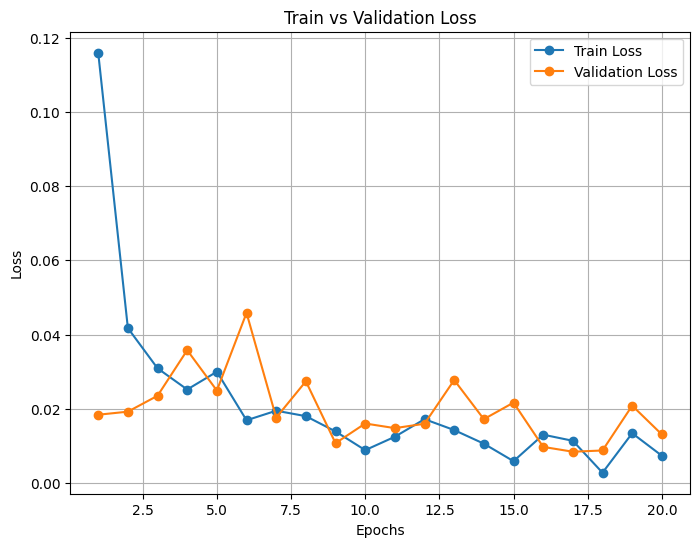

In [8]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss', marker='o')
plt.title('Train vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')  # Sauvegarder l'image pour le LaTeX
plt.show()


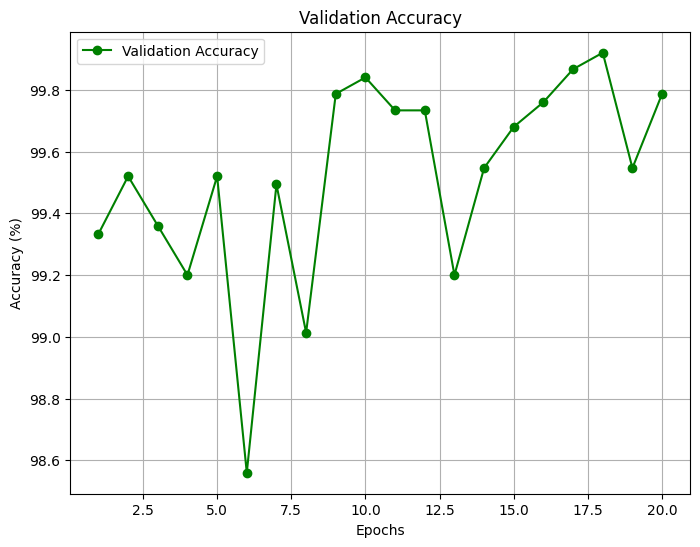

In [9]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='green', marker='o')
plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')  # Sauvegarder l'image pour le LaTeX
plt.show()
